In [1]:
import sys
import os
import osgeo  # needed only if running from Windows
from pathlib import Path
from xml.dom import minidom
import geopandas as gpd
from datetime import datetime as dt
from datetime import timedelta as td

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
sys.path.append(r"cropburn")
from timeseries import *

In [3]:
grid_file = os.path.join(r'data','Walker2023RS','Grid_Punjab_UTM.gpkg')
rec_dir = os.path.join(r'data','Walker2023RS','Img_Lists')
#local_out_dir = os.path.join(r'data',"temp")
#coords = pd.read_csv(os.path.join(local_out_dir,'SelectedCoords.csv'))
aoi_dir = os.path.join(r'data','Walker2023RS','AOIsbyCell_shp')
#aoi_id = 0
#aoi = [f for f in os.listdir(aoi_dir) if f.endswith('.shp')][aoi_id]
#aoi_file = os.path.join(aoi_dir, aoi)
cell_list = [30,31,32,38,39,46,47]

In [4]:
#pd.DataFrame.to_csv(planet_obs_grid, os.path.join(out_dir,'Planet_masked.csv'), sep=',', na_rep='NaN', index=True)

In [5]:
## the input planet, sentinel2 & landsat dataframes were created from methods in observations_stats_actual_obs 
## (from img_dir, which is not available to public due to copyright restrictions of images.) See following examples
##    the output dataframes were saved in Img_Lists and loaded below
'''
planet_ts_masked = get_timeseries_for_pts_multicell(local_out_dir, 'nir', 2019, 2019, img_dir, 'Planet', grid_file, cell_list, ground_polys=None,
            npts=3, apply_masks=True, seed=889, load_samp=True, ptfile="centroids")
planet_obs_masked = ts_to_obs_chart(planet_ts_masked, cell_list, print_df=True, out_dir=out_dir, series_name = 'planet_masked')

planet_ts_unmasked = get_timeseries_for_pts_multicell(local_out_dir, 'nir', 2019, 2019, img_dir, 'Planet', grid_file, cell_list, ground_polys=None,
            npts=3, apply_masks=False, seed=889, load_samp=True, ptfile="centroids")
planet_obs_unmasked = ts_to_obs_chart(Planet_ts_unmasked, cell_list, print_df=True, out_dir=out_dir, series_name = 'planet_unmasked')
'''

'\nplanet_ts_masked = get_timeseries_for_pts_multicell(local_out_dir, \'nir\', 2019, 2019, img_dir, \'Planet\', grid_file, cell_list, ground_polys=None,\n            npts=3, apply_masks=True, seed=889, load_samp=True, ptfile="centroids")\nplanet_obs_masked = ts_to_obs_chart(planet_ts_masked, cell_list, print_df=True, out_dir=out_dir, series_name = \'planet_masked\')\n\nplanet_ts_unmasked = get_timeseries_for_pts_multicell(local_out_dir, \'nir\', 2019, 2019, img_dir, \'Planet\', grid_file, cell_list, ground_polys=None,\n            npts=3, apply_masks=False, seed=889, load_samp=True, ptfile="centroids")\nplanet_obs_unmasked = ts_to_obs_chart(Planet_ts_unmasked, cell_list, print_df=True, out_dir=out_dir, series_name = \'planet_unmasked\')\n'

In [93]:
planet_obs_masked = load_TS_from_file(os.path.join(rec_dir,"obs_planet_masked.csv"))
planet_obs_masked_dos = convert_timeseries_to_doy(planet_obs_masked, 2019, start_day=283, end_day=346, season=True)
planet_obs_unmasked = load_TS_from_file(os.path.join(rec_dir,"obs_planet_unmasked.csv"))
planet_obs_unmasked_dos = convert_timeseries_to_doy(planet_obs_unmasked, 2019, start_day=283, end_day=346, season=True)
sentinel_obs_masked = load_TS_from_file(os.path.join(rec_dir,"obs_sentinel_masked.csv"))
sentinel_obs_masked_dos = convert_timeseries_to_doy(sentinel_obs_masked, 2019, start_day=283, end_day=346, season=True)
sentinel_obs_unmasked = load_TS_from_file(os.path.join(rec_dir,"obs_sentinel_unmasked.csv"))
sentinel_obs_unmasked_dos = convert_timeseries_to_doy(sentinel_obs_unmasked, 2019, start_day=283, end_day=346, season=True)
landsat_obs_masked = load_TS_from_file(os.path.join(rec_dir,"obs_landsat_masked.csv"))
landsat_obs_masked_dos = convert_timeseries_to_doy(landsat_obs_masked, 2019, start_day=283, end_day=346, season=True)
landsat_obs_unmasked = load_TS_from_file(os.path.join(rec_dir,"obs_landsat_unmasked.csv"))
landsat_obs_unmasked_dos = convert_timeseries_to_doy(landsat_obs_unmasked, 2019, start_day=283, end_day=346, season=True)

In [94]:
planet_clear = np.equal(planet_obs_unmasked_dos, planet_obs_masked_dos)
planet_clear1 = planet_obs_unmasked_dos[planet_clear].fillna(0).astype(int)
planet_cloudy = planet_obs_unmasked_dos[~planet_clear].fillna(0).astype(int)
sentinel_clear = np.equal(sentinel_obs_unmasked_dos, sentinel_obs_masked_dos)
sentinel_clear1 = sentinel_obs_unmasked_dos[sentinel_clear].fillna(0).astype(int)
sentinel_cloudy = sentinel_obs_unmasked_dos[~sentinel_clear].fillna(0).astype(int)
landsat_clear = np.equal(landsat_obs_unmasked_dos, landsat_obs_masked_dos)
landsat_clear1 = landsat_obs_unmasked_dos[landsat_clear].fillna(0).astype(int)
landsat_cloudy = landsat_obs_unmasked_dos[~landsat_clear].fillna(0).astype(int)

In [151]:
start = dt.strptime("10-10-2019", "%d-%m-%Y")
end = dt.strptime("20-12-2019", "%d-%m-%Y")
print(f'range is {end-start}')
date_labels = [((start - td(days=1))+ td(days=x)).strftime('%d-%m') for x in range(0,(end-start).days,2)]
print('starting at:', date_labels[0])

range is 71 days, 0:00:00
starting at: 09-10


## add histogram of viirs data (for underlay):

In [96]:
active_fire_dir = os.path.join(r'data','active_fires')
aoi_file = os.path.join(r'data','AOIs','cell31.shp')
viirs_file = [f for f in os.listdir(active_fire_dir) if f.startswith('fire_archive_SV-C2') and f.endswith('.shp')]

## if aoi is single polygon shapefile:
viirs = gpd.read_file(os.path.join(active_fire_dir,viirs_file[0]))
aoi = gpd.read_file(aoi_file)
print("viirs data are in:", viirs.crs)
print("original aoi file is in:", aoi.crs)
if aoi.crs != viirs.crs:
    print("aoi file was in{}: converted to:{} to match viirs".format(aoi.crs, viirs.crs))
    aoi = aoi.to_crs(viirs.crs)
viirs_clip = gpd.clip(viirs, aoi)
print ('there are {} active fire points in this period for this aoi'.format(len(viirs_clip)))

viirs_bydate = viirs_clip.groupby(['ACQ_DATE'])['ACQ_DATE'].size().reset_index(name='counts')
print ('there are {} burn days observed in this season'.format(len(viirs_bydate)))
viirs_bydate["obs_date"] = pd.to_datetime(viirs_bydate['ACQ_DATE'])
viirs_bydate.set_index("obs_date", inplace=True)

season_first = viirs_bydate.index[0]
season_last = viirs_bydate.index[-1]
print('the season is from {} to {}'.format(season_first, season_last))
print('the season is {} days'.format( (viirs_bydate.index[-1] - viirs_bydate.index[0] ).days))

viirs_doy = convert_timeseries_to_doy(viirs_bydate, 2019, start_day=283, end_day=346, season=True)

viirs data are in: EPSG:4326
original aoi file is in: EPSG:7773
aoi file was inEPSG:7773: converted to:EPSG:4326 to match viirs
there are 166 active fire points in this period for this aoi
there are 15 burn days observed in this season
the season is from 2019-10-23 00:00:00 to 2019-11-21 00:00:00
the season is 29 days


## add PM2 data (for underlay):

In [122]:
pollution_data = pd.read_csv('./data/PM25/Punjab_Bhatinda.csv', usecols=['From Date', 'PM2.5'])
# change 'None' to legit NaNs:
pollution_data["PM2.5"] = pd.to_numeric(pollution_data["PM2.5"], errors='coerce')
# convert to time series:
pollution_data['From Date'] = pd.to_datetime(pollution_data['From Date'])
pollution_ts = pollution_data[pollution_data['From Date'] > pd.Timestamp(2019,10,9)]
pollution_daily = pollution_ts.set_index('From Date').resample('D')['PM2.5'].mean()
#pollution_daily.dropna(axis=0, inplace=True)
#pollution_daily = pollution_daily.astype(np.int64)
print('max PM2.5 value is {}, Min value is {}'.format(pollution_daily.max(), pollution_daily.min()))
pollution_doy = convert_timeseries_to_doy(pollution_daily, 2019, start_day=283, end_day=343, season=True)
pollution_doy.head()

max PM2.5 value is 223.0695, Min value is 11.397333333333334


From Date
1    27.234583
2    70.958750
3    58.074167
4    35.095417
5    38.424167
Name: PM2.5, dtype: float64

C:\Users\klobw\AppData\Local\Temp\ipykernel_8612\3878458711.py:10: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.get_shared_x_axes().join(ax1, ax2)
C:\Users\klobw\AppData\Local\Temp\ipykernel_8612\3878458711.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(date_labels, rotation='vertical', fontsize=18, fontname='Palatino Linotype')
C:\Users\klobw\AppData\Local\Temp\ipykernel_8612\3878458711.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(cell_labels, fontsize=18, fontname='Palatino Linotype')


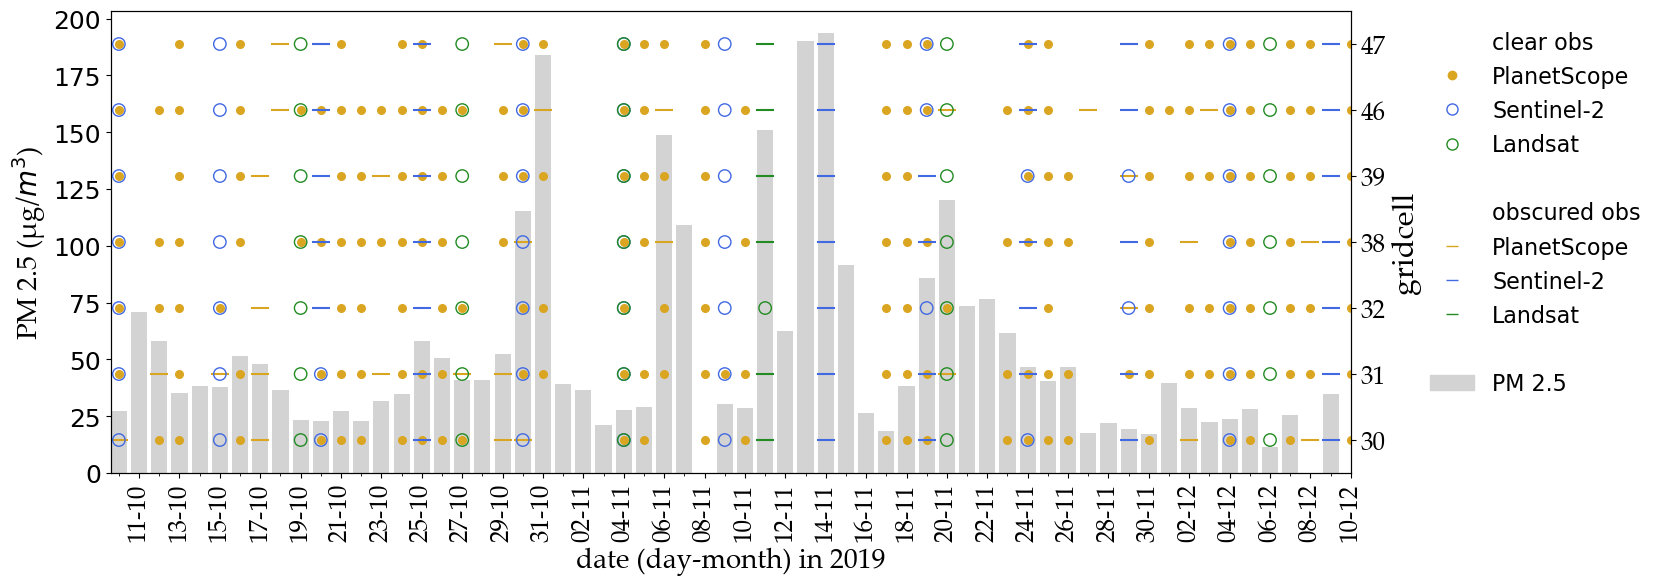

In [153]:

cell_labels = [0] + cell_list

#fig, ax1 = plt.subplots(figsize=(16,6))
fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(111)
ax1.margins(x=0)
ax2 = ax1.twinx()
ax2.margins(x=0)
ax1.get_shared_x_axes().join(ax1, ax2)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax1.set_xticklabels(date_labels, rotation='vertical', fontsize=18, fontname='Palatino Linotype')

#ax1.set_ylabel('VIIRSaf count') 
#ax1.bar(viirs_doy.index, viirs_doy['counts'], color='lightgray')

#ax1.plot(pollution_doy.index, pollution_doy)
ax1.bar(pollution_doy.index, pollution_doy, color='lightgray')
ax1.set_ylabel('PM 2.5 (μg/$m^3$)', fontsize=20, fontname='Palatino Linotype') 

ax1.set_xlabel('date (day-month) in 2019', fontsize=20, fontname='Palatino Linotype')
ax1.yaxis.set_tick_params(labelsize=18)


for column in planet_obs_unmasked_dos:
    #plt.scatter(planet_clear1.index, planet_clear1[column], s=60, facecolors='none', edgecolors='goldenrod', marker="o")
    ax2.scatter(planet_clear1.index, planet_clear1[column], s=30, color='goldenrod', marker="o")
for column in planet_cloudy:
    ax2.scatter(planet_cloudy.index, planet_cloudy[column],color='goldenrod', s=150, marker="_")
for column in sentinel_obs_unmasked_dos:
    ax2.scatter(sentinel_clear1.index, sentinel_clear1[column], s=80, facecolors='none', edgecolors='royalblue', marker="o")
     #plt.scatter(sentinel_clear1.index, sentinel_clear1[column], s=10, color ='royalblue', marker="o")
    #plt.scatter(sentinel_clear1.index, sentinel_clear1[column], s=10, color ='royalblue', marker="o", label='_')
for column in sentinel_cloudy:
    ax2.scatter(sentinel_cloudy.index, sentinel_cloudy[column], s=150, color='royalblue', marker="_")

for column in landsat_obs_unmasked_dos:
    ax2.scatter(landsat_clear1.index, landsat_clear1[column], s=80, facecolors='none', edgecolors='forestgreen')
    #plt.scatter(landsat_clear1.index, landsat_clear1[column], s=10, color ='forestgreen', marker="o")
for column in landsat_cloudy:
    ax2.scatter(landsat_cloudy.index, landsat_cloudy[column], s=150, color='forestgreen', marker="_")

ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.set_yticklabels(cell_labels, fontsize=18, fontname='Palatino Linotype')
ax2.set_ylabel('gridcell', fontsize=22, fontname='Palatino Linotype')

PM25 = mpatches.Patch(color='lightgray', label='PM 2.5')    

clear_obs = mlines.Line2D([],[], markeredgecolor='none', color='none', label='clear obs')
sentinel_obs = mlines.Line2D([],[], markeredgecolor='royalblue', color='none', marker="o", markersize=8, label='Sentinel-2')
landsat_obs = mlines.Line2D([],[], markeredgecolor='forestgreen', color='none', marker="o", markersize=8, label='Landsat')
planet_obs = mlines.Line2D([],[], color='goldenrod', marker="o", markersize=6, linewidth=0, label='PlanetScope')
space = mlines.Line2D([],[], markeredgecolor='none', color='none', label='')
obscured_obs = mlines.Line2D([],[], markeredgecolor='none', color='none', label='obscured obs')
planet_miss = mlines.Line2D([],[], color='goldenrod', marker="_", markersize=8, linewidth=0, label='PlanetScope')
landsat_miss = mlines.Line2D([],[], color='forestgreen', marker="_", markersize=8, linewidth=0, label='Landsat')
sentinel_miss = mlines.Line2D([],[], color='royalblue', marker="_", markersize=8,linewidth=0, label='Sentinel-2')

plt.ylim(.5,7.5)
ax1.legend(handles=[clear_obs,planet_obs,sentinel_obs,landsat_obs,space,obscured_obs,planet_miss,sentinel_miss,landsat_miss,space,PM25], 
           loc='upper right', bbox_to_anchor=(1.25, 1), fontsize="16", frameon=False)

plt.show()